In [6]:
import os
import pandas as pd
import sagemaker
import boto3
import json
import pprint as pp
import os
import shutil
import csv
import time
import pprint
import base64
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

#get bedrock instances with boto3
bedrock = boto3.client('bedrock')
bedrock_client = boto3.client('bedrock-runtime')

In [2]:
# load the dataset from notebook 1 
%store -r df_images

In [3]:
df_images.head()

,image_id,path,title,description,tags,keywords,embeddings
0,00c73a28068f9b33.jpg,./data/curated-images/00c73a28068f9b33.jpg,,,[],[],[]
1,00a7655d4eabf186.jpg,./data/curated-images/00a7655d4eabf186.jpg,,,[],[],[]
2,039928928a45ca04.jpg,./data/curated-images/039928928a45ca04.jpg,,,[],[],[]
3,07080581c9f69bf9.jpg,./data/curated-images/07080581c9f69bf9.jpg,,,[],[],[]
4,0a1a999ef52a93f2.jpg,./data/curated-images/0a1a999ef52a93f2.jpg,,,[],[],[]


# Enrichment using Bedrock

In [4]:
# helper functions for generating metadata and creating some previews

modelid = 'anthropic.claude-3-sonnet-20240229-v1:0'


def image_to_base64(path):
    # Read reference image from file and encode as base64 strings.
    content_image = ""
    with open(path, "rb") as image_file:
        content_image = base64.b64encode(image_file.read()).decode('utf8')
    return content_image

def generate_metadata(bedrock_runtime, model_id, messages, max_tokens,top_p,temp):

    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": messages,
            "temperature": temp,
            "top_p": top_p
        }  
    )  
    
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())
    response_text = response_body["content"][0]["text"]    

    return response_text

def bulk_extract_metadata(df_images):
    return df_images    

def display_image(path):
    im = Image.open(path)
    plt.imshow(im)
    plt.figure(figsize=(10, 10))
    plt.show()

### Test Enrichment of single media asset

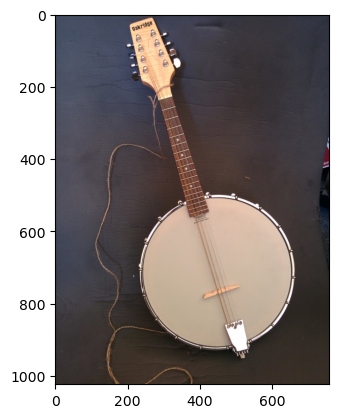

<Figure size 1000x1000 with 0 Axes>

In [7]:
# first enrich a single image 
# view the image we are trying to process - randomly pick an item
test_image_path = df_images.sample()["path"].values[0]
display_image(test_image_path)

In [8]:
# enrichment prompt 

# prepapre the request payload for Claude 

# prepare the multimodal content message input for Claude 3 (separate json objects for image and text)
# define a prompt to get a title, description, tags, keywords from Claude 
# follow the costar principle (context, objective, style, tone, audience, response) 
prompt = """
You are a multimodal search engine metadata extractor. Your task is to carefully study the image, and extract tags, keywords, description, any text contained in the image, as well as forming a succinct title for the image.
Do not generated unwanted and uncessarily metadata, that will bloat the payload. Be detailed on various aspects of the image such as background, foreground and subject of the image.
If media contains no OCR texts then simply generate an empty string for it. 
Make necessary determination on the key category/theme of the image and generate keywords as appropriate. 

All metadata extracted is required to be professional for official use. Refrain from using informal language. 

The intended audience are various business users who will attempt to search based on keywords or describing in natural language what they are looking for. For this purpose generate a description the image and include finer details that can be used for search purposes alongisde keywords and tags. 

Output the metadata as well formed JSON as defined in the <example> XML tags. Do not include XML tags in the output.  

<example>
    {
        "title":"baseball player swinging bat",
        "description":"baseball player wearing team jersey swinging bat to score a home run. In the background there are cheering fans who are joyous and having a wonderful time. Stadium atmosphere seems electric.",
        "keywords":"baseball, sports, homerun, bat, player, jersey",
        "tags":"sports, stadium, baseball, crowd"
        "ocr_texts":"new york mets, mets, new york, richardson, 66"
    }
<example>
"""

def prepare_mm_input(path):
    # Read reference image from file and encode as base64 strings.
    content_image = image_to_base64(path)
    message_mm = [
        { "role": "user",
          "content": [
          {"type": "image","source": { "type": "base64","media_type":"image/jpeg","data": content_image}},
          {"type": "text","text": prompt}
          ]
        }
    ]
    return message_mm

In [11]:
# test the single image 
# note: the enriched output quality will vary depending on quality of image (ie. blurry text) 
message_mm = prepare_mm_input(test_image_path)
response = generate_metadata(bedrock_client, model_id = modelid,messages=message_mm,max_tokens=512,temp=0.5,top_p=0.9)

In [12]:
pprint.pp(response)

('{\n'
 '    "title": "Banjo Guitar Hybrid Instrument",\n'
 '    "description": "The image shows a unique musical instrument that '
 'combines elements of a banjo and a guitar. The body of the instrument is a '
 'round banjo-like drum with a taut skin surface, while the neck and headstock '
 'resemble those of a guitar, featuring tuning pegs and frets. The instrument '
 'appears to be handcrafted or custom-made, with a wooden construction and a '
 'simple, rustic aesthetic.",\n'
 '    "keywords": "banjo, guitar, hybrid, instrument, music, strings, frets, '
 'tuning pegs, handcrafted, custom",\n'
 '    "tags": "musical instrument, stringed instrument, banjo, guitar, hybrid, '
 'custom-made",\n'
 '    "ocr_texts": "DAKOTAH"\n'
 '}')


### Bulk metadata extraction 

Now that we can verify keywords can be extracted let us process all the images in bulk 

Note: This process may take several minutes 



In [13]:
import time
from multiprocessing.dummy import Pool as ThreadPool 

pool = ThreadPool(5) 

# called by each thread
def get_metadata(item):
    message_mm = prepare_mm_input(item[1])
    response = generate_metadata(bedrock_client, model_id = modelid,messages=message_mm,max_tokens=512,temp=0.5,top_p=0.9)
    json_response = json.loads(response)
    response = {
        "image_id":item[0],
        "path":item[1],
        "title":json_response["title"],
        "description":json_response["description"],
        "keywords":json_response["keywords"],
        "tags":json_response["tags"]
    }
    return response


list_images = df_images.values.tolist()
start_time = time.time()
results = pool.map(get_metadata, list_images)
duration = time.time() - start_time
print(f"Processed {len(list_images)} in {duration} seconds")

Processed 292 in 299.40419268608093 seconds


In [15]:
df_metadata = pd.DataFrame(results)
df_metadata.head()

,image_id,path,title,description,keywords,tags
0,00c73a28068f9b33.jpg,./data/curated-images/00c73a28068f9b33.jpg,Majestic Mountain Lion in Repose,The image captures a magnificent mountain lion...,"mountain lion, cougar, puma, big cat, wildlife...","nature, animal, mammal, wild, outdoor"
1,00a7655d4eabf186.jpg,./data/curated-images/00a7655d4eabf186.jpg,Baseball batter in mid-swing,The image depicts a baseball player in the mid...,"baseball, batter, swing, game, sports, athlete...","baseball, sports, athlete, batting, action"
2,039928928a45ca04.jpg,./data/curated-images/039928928a45ca04.jpg,Music Production Setup with Guitar and Accesso...,The image depicts a music production setup wit...,"guitar, music production, electric guitar, fre...","music, instruments, recording, studio, setup"
3,07080581c9f69bf9.jpg,./data/curated-images/07080581c9f69bf9.jpg,Musicians performing in an office setting,The image depicts three young men dressed in f...,"musicians, music performance, office, workspac...","music, office, performance, instruments, formal"
4,0a1a999ef52a93f2.jpg,./data/curated-images/0a1a999ef52a93f2.jpg,Majestic Lion in Natural Habitat,The image depicts a magnificent lion with a fu...,"lion, wildlife, nature, safari, big cat, preda...","animal, mammal, feline, carnivore, wild, outdoor"


## Generate Embeddings

Use titan multi-modal embedding model (titan-embed-image-v1) to create embeddings of the images as an alternative mechanism/method to carry out smart search. 